## Imports

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer ## for handling the missing values
import seaborn as sns ## for data visualization
from sklearn.model_selection import train_test_split

## Get CSV File 

In [ ]:
filepath = '../data/California_Houses.csv'
df = pd.read_csv(filepath)

### Print 1st 5 Rows using head

In [61]:
print(df.columns.tolist())
print(df.head())
print(df.shape)

['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms', 'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         5

### Before Training the model, make sure there are no missing values in your dataset

In [62]:
print(df.isnull().sum())
## All values were zero meaning there are no null values in this dataset

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64


### Separate Features and Target Value

Mean House Value:  206855.81690891474


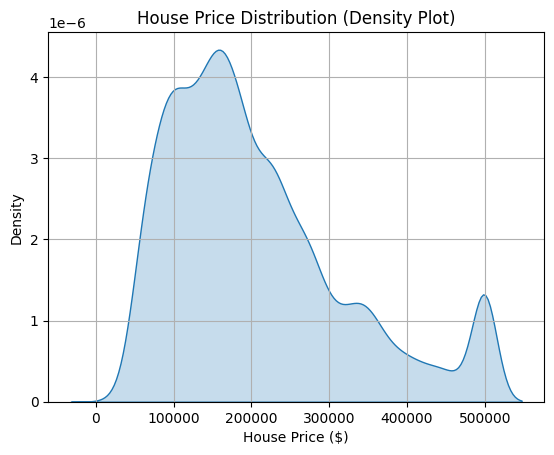

In [63]:
X= df.drop("Median_House_Value",axis=1)
# drop the target column(median house value) and leaving only the independent features

y=df["Median_House_Value"]
# y is the target value

print("Mean House Value: ",y.mean())

sns.kdeplot(data=df,x="Median_House_Value",fill=True)

plt.xlabel("House Price ($)")
plt.ylabel("Density")
plt.title("House Price Distribution (Density Plot)")
plt.grid(True)
plt.show()

Notice that there are some Outliers might need to exlude them to improve the accuracy

# Data Splitting

In [64]:
X_train, X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.30,random_state=42)

##train_test_split is used to split dataset into a training set and a temporary one to use again to split it to validation and test sets
X_validation,X_test,y_validation,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

# Linear Regression Model

In [65]:

## All imports for this part
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Scaling training
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

#  Train the Linear Regression model
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_train_scaled, y_train)

#  Predictions
y_pred_train_lin_sk = lin_reg_sk.predict(X_train_scaled)
y_pred_val_lin_sk   = lin_reg_sk.predict(X_validation_scaled)
y_pred_test_lin_sk  = lin_reg_sk.predict(X_test_scaled)

#  Compute mse - mae
mse_train_lin_sk = mean_squared_error(y_train, y_pred_train_lin_sk)
mae_train_lin_sk = mean_absolute_error(y_train, y_pred_train_lin_sk)

mse_val_lin_sk = mean_squared_error(y_validation, y_pred_val_lin_sk)
mae_val_lin_sk = mean_absolute_error(y_validation, y_pred_val_lin_sk)

mse_test_lin_sk = mean_squared_error(y_test, y_pred_test_lin_sk)
mae_test_lin_sk = mean_absolute_error(y_test, y_pred_test_lin_sk)

#  Display results of linear regression - STANDARD
print("Linear Regression (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_lin_sk:.2f},  MAE: {mae_train_lin_sk:.2f}")
print(f"Validation MSE: {mse_val_lin_sk:.2f},  MAE: {mae_val_lin_sk:.2f}")
print(f"Test MSE: {mse_test_lin_sk:.2f},  MAE: {mae_test_lin_sk:.2f}")

Linear Regression (Scikit-Learn) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


# Ridge Regression — Validation Error vs. α

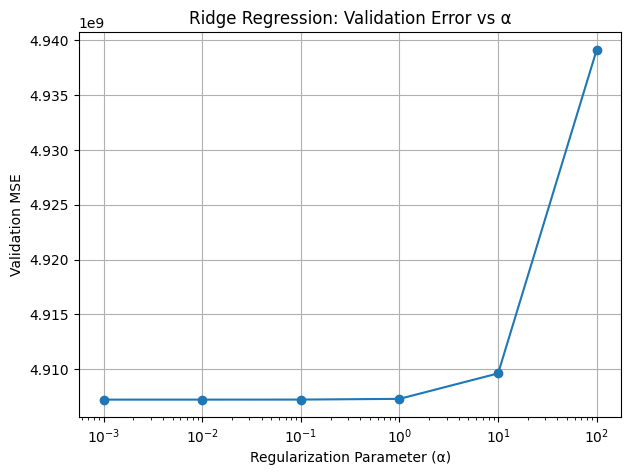

In [ ]:
# imports needed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ridge regression -> for regularization & overfitting the model
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_mse = []
ridge_mae = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_validation_scaled)
    
    ridge_mse.append(mean_squared_error(y_validation, y_pred_val))
    ridge_mae.append(mean_absolute_error(y_validation, y_pred_val))

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, ridge_mse, marker='o')
plt.xscale('log')
plt.title("Ridge Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()


# Lasso Regression — Validation Error vs. α

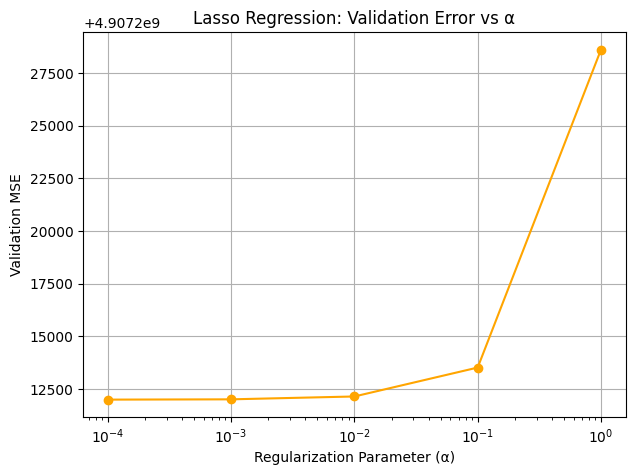

In [ ]:
# imports needed
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# lasso regression -> for regularization of absolute weights
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
lasso_mse = []
lasso_mae = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred_val = lasso.predict(X_validation_scaled)
    
    lasso_mse.append(mean_squared_error(y_validation, y_pred_val))
    lasso_mae.append(mean_absolute_error(y_validation, y_pred_val))

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, lasso_mse, marker='o', color='orange')
plt.xscale('log')
plt.title("Lasso Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()
